In [21]:
# ------------------------------------------------------------------------------
# Face Enrollment Prototype (MVP)
# End-to-end enrollment pipeline for step-up authentication.
# ------------------------------------------------------------------------------

# Face Enrollment Prototype (MVP)
# - Accept 1–3 images for a user
# - Detect exactly 1 face per image
# - Align + embed (ArcFace via InsightFace)
# - Compute quality metrics
# - Store: individual embeddings + mean template
# - Simulate persistence (dict / parquet), later pgvector


If you don't have the dependencies installed, run:
```
%pip install -q insightface onnxruntime opencv-python numpy pandas pydantic matplotlib pyarrow
```


In [22]:
%pip install -q insightface onnxruntime opencv-python numpy pandas pydantic matplotlib pyarrow


Note: you may need to restart the kernel to use updated packages.


In [23]:
# ------------------------------------------------------------------------------
# Imports: standard libs, CV utilities, and InsightFace
# ------------------------------------------------------------------------------

from __future__ import annotations

import os
import json
import time
import uuid
from dataclasses import dataclass
from datetime import datetime, timezone
from pathlib import Path
from typing import List, Dict, Any, Tuple

import cv2
import numpy as np
import pandas as pd



from insightface.app import FaceAnalysis    


In [24]:
# ------------------------------------------------------------------------------
# Resolve repo root and local enrollment data directory
# ------------------------------------------------------------------------------

from pathlib import Path

def find_repo_root(start: Path | None = None) -> Path:
    """
    Walk upward until we find a marker file that indicates the repo root.
    Works even if the notebook lives in nested folders like notebooks/notebooks/.
    """
    p = (start or Path.cwd()).resolve()
    markers = ["pyproject.toml", ".git"]  # pick what exists in your repo
    for _ in range(15):  # avoid infinite loops
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    raise FileNotFoundError("Could not locate repo root (pyproject.toml or .git not found).")

REPO_ROOT = find_repo_root()
print("REPO_ROOT:", REPO_ROOT)

DATA_DIR = REPO_ROOT / "data"
ENROLLMENT_SAMPLES_DIR = DATA_DIR / "enrollment_samples"
print("DATA_DIR exists:", DATA_DIR.exists(), DATA_DIR)
print("ENROLLMENT_SAMPLES_DIR exists:", ENROLLMENT_SAMPLES_DIR.exists(), ENROLLMENT_SAMPLES_DIR)

if not ENROLLMENT_SAMPLES_DIR.exists():
    raise FileNotFoundError(
        "Missing local enrollment samples. Expected: <repo>/data/enrollment_samples"
    )
import sys
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))



REPO_ROOT: C:\Users\l\Documents\Formation\fraud_detection_analysis
DATA_DIR exists: True C:\Users\l\Documents\Formation\fraud_detection_analysis\data
ENROLLMENT_SAMPLES_DIR exists: True C:\Users\l\Documents\Formation\fraud_detection_analysis\data\enrollment_samples


In [25]:
# ------------------------------------------------------------------------------
# Global configuration and quality thresholds
# ------------------------------------------------------------------------------

MODEL_PACK = "buffalo_l"   # includes detection + recognition
MODEL_NAME = "arcface"     # logical name you store
MODEL_VERSION = "buffalo_l@insightface"  # store something stable

MAX_IMAGES = 3
MIN_IMAGES = 1

MIN_FACE_WIDTH_PX = 90
MIN_DET_SCORE = 0.5             # detection confidence threshold
MAX_YAW_ABS = 30                 # optional; degrees (if you compute pose)
MAX_PITCH_ABS = 20               # optional

# Quality thresholds (tune later via plots)
BLUR_MIN_LAPLACIAN_VAR = 8.0
BRIGHTNESS_MIN = 25
BRIGHTNESS_MAX = 235
MIN_FACE_AREA_RATIO = 0.02      # bbox area / image area

OUTPUT_DIR = Path("../artifacts/face_enrollment")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

np.random.seed(0)


In [26]:
# ------------------------------------------------------------------------------
# Initialize InsightFace FaceAnalysis (CPU)
# ------------------------------------------------------------------------------

app = FaceAnalysis(name=MODEL_PACK)
# ctx_id=0 uses GPU if available; -1 forces CPU
app.prepare(ctx_id=-1, det_size=(640, 640))

print("Loaded:", MODEL_PACK)


c:\Users\l\Documents\Formation\fraud_detection_analysis\.venv311\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\l/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\l/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\l/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\l/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\l/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size

In [27]:
# ------------------------------------------------------------------------------
# Image loading utilities
# ------------------------------------------------------------------------------

def load_image_bgr(path: str | Path) -> np.ndarray:
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    return img

def list_images(folder: str | Path) -> List[Path]:
    folder = Path(folder)
    exts = {".jpg", ".jpeg", ".png"}
    return [p for p in sorted(folder.iterdir()) if p.suffix.lower() in exts]


In [28]:
from src.face.quality import (
    blur_laplacian_var,
    brightness_mean,
    face_area_ratio,
    bbox_width,
    quality_checks,
    passes_quality,
)


In [29]:
# ------------------------------------------------------------------------------
# Face detection and validation gates
# ------------------------------------------------------------------------------

class EnrollmentError(Exception):
    pass

def detect_one_face(bgr: np.ndarray):
    faces = app.get(bgr)
    if len(faces) != 1:
        raise EnrollmentError(f"Expected exactly 1 face, got {len(faces)}")
    face = faces[0]

    # detection score and bbox checks
    if getattr(face, "det_score", 1.0) < MIN_DET_SCORE:
        raise EnrollmentError(f"Detection score too low: {face.det_score:.3f}")

    bw = bbox_width(face.bbox)
    if bw < MIN_FACE_WIDTH_PX:
        raise EnrollmentError(f"Face too small: bbox_width={bw:.1f}px")

    return face


In [30]:
# ------------------------------------------------------------------------------
# Embedding extraction and normalization
# ------------------------------------------------------------------------------

def l2_normalize(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    n = np.linalg.norm(x) + 1e-12
    return x / n

def extract_embedding(face) -> np.ndarray:
    # InsightFace typically returns L2-normalized already, but normalize anyway.
    emb = np.asarray(face.embedding, dtype=np.float32)
    return l2_normalize(emb)


In [31]:
# Quality evaluation now imported from src.face.quality


In [32]:
# ------------------------------------------------------------------------------
# Template record schema (mirrors pgvector persistence)
# ------------------------------------------------------------------------------

@dataclass
class TemplateRecord:
    template_id: str
    user_id: str
    embedding: np.ndarray
    is_mean_template: bool
    model_name: str
    model_version: str
    quality: Dict[str, Any]
    created_at: str

def now_iso() -> str:
    return datetime.now(timezone.utc).isoformat()


In [33]:
# ------------------------------------------------------------------------------
# Enrollment pipeline (core logic)
# ------------------------------------------------------------------------------

def enroll_user_from_images(user_id: str, image_paths: List[Path]) -> Dict[str, Any]:
    if not (MIN_IMAGES <= len(image_paths) <= MAX_IMAGES):
        raise EnrollmentError(f"Need {MIN_IMAGES}–{MAX_IMAGES} images, got {len(image_paths)}")

    template_records: List[TemplateRecord] = []
    embeddings: List[np.ndarray] = []
    per_image_quality: List[Dict[str, Any]] = []

    for p in image_paths:
        bgr = load_image_bgr(p)

        face = detect_one_face(bgr)
        q = quality_checks(bgr, face.bbox)
        ok, reasons = passes_quality(
    q,
    blur_min_laplacian_var=BLUR_MIN_LAPLACIAN_VAR,
    brightness_min=BRIGHTNESS_MIN,
    brightness_max=BRIGHTNESS_MAX,
    min_face_area_ratio=MIN_FACE_AREA_RATIO,
)
        q["quality_ok"] = ok
        q["reject_reasons"] = reasons
        q["det_score"] = float(getattr(face, "det_score", 1.0))

        if not ok:
            raise EnrollmentError(
    f"Quality reject for {p.name}: {reasons} | "
    f"blur={q['blur_laplacian_var']:.1f}, "
    f"bright={q['brightness_mean']:.1f}, "
    f"ratio={q['face_area_ratio']:.3f}, "
    f"bbox_w={q['bbox_width_px']:.1f}, "
    f"det={q['det_score']:.3f}"
)


        emb = extract_embedding(face)

        template_id = str(uuid.uuid4())
        template_records.append(
            TemplateRecord(
                template_id=template_id,
                user_id=user_id,
                embedding=emb,
                is_mean_template=False,
                model_name=MODEL_NAME,
                model_version=MODEL_VERSION,
                quality=q,
                created_at=now_iso(),
            )
        )
        embeddings.append(emb)
        per_image_quality.append(q)

    # mean template
    mean_emb = l2_normalize(np.mean(np.stack(embeddings, axis=0), axis=0))
    template_records.append(
        TemplateRecord(
            template_id=str(uuid.uuid4()),
            user_id=user_id,
            embedding=mean_emb,
            is_mean_template=True,
            model_name=MODEL_NAME,
            model_version=MODEL_VERSION,
            quality={"note": "mean_template_from_individuals", "num_sources": len(embeddings)},
            created_at=now_iso(),
        )
    )

    response = {
        "user_id": user_id,
        "enrolled": True,
        "num_templates": len(template_records),
        "num_individual_templates": len(embeddings),
        "stored_mean_template": True,
        "model": MODEL_VERSION,
        "templates": template_records,
        "per_image_quality": per_image_quality,
    }
    return response


In [34]:
# ------------------------------------------------------------------------------
# Quality scan of sample images (pre-enrollment)
# ------------------------------------------------------------------------------

user_id = "user_123"
img_dir = ENROLLMENT_SAMPLES_DIR / user_id
paths = list_images(img_dir)[:3]

rows = []
for p in paths:
    bgr = load_image_bgr(p)
    faces = app.get(bgr)

    row = {"file": p.name, "num_faces": len(faces)}
    if len(faces) == 1:
        face = faces[0]
        q = quality_checks(bgr, face.bbox)
        q["det_score"] = float(getattr(face, "det_score", 1.0))
        ok, reasons = passes_quality(
    q,
    blur_min_laplacian_var=BLUR_MIN_LAPLACIAN_VAR,
    brightness_min=BRIGHTNESS_MIN,
    brightness_max=BRIGHTNESS_MAX,
    min_face_area_ratio=MIN_FACE_AREA_RATIO,
)
        row.update(q)
        row["quality_ok"] = ok
        row["reject_reasons"] = ",".join(reasons)
    rows.append(row)

dfq = pd.DataFrame(rows)
dfq


c:\Users\l\Documents\Formation\fraud_detection_analysis\.venv311\Lib\site-packages\insightface\utils\face_align.py:23: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(lmk, dst)


,file,num_faces,blur_laplacian_var,brightness_mean,face_area_ratio,bbox_width_px,det_score,quality_ok,reject_reasons
0,WIN_20260206_12_45_37_Pro.jpg,1,8.081144,129.144322,0.143248,304.177094,0.784642,True,
1,WIN_20260206_12_45_41_Pro.jpg,1,13.732615,128.239375,0.135392,294.337402,0.715901,True,
2,WIN_20260206_12_45_44_Pro.jpg,1,15.078793,127.877875,0.137489,295.608765,0.738799,True,


In [35]:
# ------------------------------------------------------------------------------
# Run enrollment on a sample user
# ------------------------------------------------------------------------------

user_id = "user_123"
img_dir = ENROLLMENT_SAMPLES_DIR / user_id

print("img_dir:", img_dir, "exists:", img_dir.exists())
paths = list_images(img_dir)[:3]
print("found images:", len(paths), [p.name for p in paths])

result = enroll_user_from_images(user_id=user_id, image_paths=paths)
print({
    "user_id": result["user_id"],
    "enrolled": result["enrolled"],
    "num_templates": result["num_templates"],
    "model": result["model"],
})


img_dir: C:\Users\l\Documents\Formation\fraud_detection_analysis\data\enrollment_samples\user_123 exists: True
found images: 3 ['WIN_20260206_12_45_37_Pro.jpg', 'WIN_20260206_12_45_41_Pro.jpg', 'WIN_20260206_12_45_44_Pro.jpg']


c:\Users\l\Documents\Formation\fraud_detection_analysis\.venv311\Lib\site-packages\insightface\utils\face_align.py:23: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(lmk, dst)


{'user_id': 'user_123', 'enrolled': True, 'num_templates': 4, 'model': 'buffalo_l@insightface'}


In [36]:
# ------------------------------------------------------------------------------
# Convert templates to tabular form
# ------------------------------------------------------------------------------

def template_to_row(t: TemplateRecord) -> Dict[str, Any]:
    return {
        "template_id": t.template_id,
        "user_id": t.user_id,
        "is_mean_template": t.is_mean_template,
        "model_name": t.model_name,
        "model_version": t.model_version,
        "created_at": t.created_at,
        "quality_json": json.dumps(t.quality),
        "embedding": t.embedding.tolist(),   # for notebook artifact; pgvector will store vector directly
    }

rows = [template_to_row(t) for t in result["templates"]]
df = pd.DataFrame(rows)
df.head()


,template_id,user_id,is_mean_template,model_name,model_version,created_at,quality_json,embedding
0,dc2a5960-096d-41d8-854d-cf607fd4d1b1,user_123,False,arcface,buffalo_l@insightface,2026-02-06T16:04:27.239668+00:00,"{""blur_laplacian_var"": 8.081144086668226, ""bri...","[0.04680231213569641, 0.028721217066049576, 0...."
1,9aa65948-8790-4495-a866-9ca4973b48ae,user_123,False,arcface,buffalo_l@insightface,2026-02-06T16:04:27.780326+00:00,"{""blur_laplacian_var"": 13.732615009825905, ""br...","[0.03495236113667488, 0.02492390014231205, 0.0..."
2,21256cbb-c7b2-4932-b8b7-e4c54e8b9b30,user_123,False,arcface,buffalo_l@insightface,2026-02-06T16:04:28.216897+00:00,"{""blur_laplacian_var"": 15.078793401251898, ""br...","[0.024583136662840843, 0.029344934970140457, 0..."
3,eb596143-cc8e-4217-b515-bab6564bce37,user_123,True,arcface,buffalo_l@insightface,2026-02-06T16:04:28.217899+00:00,"{""note"": ""mean_template_from_individuals"", ""nu...","[0.03625284880399704, 0.028293095529079437, 0...."


In [37]:
# ------------------------------------------------------------------------------
# Persist enrollment artifacts (JSON + Parquet)
# ------------------------------------------------------------------------------

out_json = OUTPUT_DIR / f"enrollment_{result['user_id']}.json"
out_parquet = OUTPUT_DIR / f"enrollment_{result['user_id']}.parquet"

with open(out_json, "w", encoding="utf-8") as f:
    json.dump({
        "user_id": result["user_id"],
        "model": result["model"],
        "num_templates": result["num_templates"],
        "templates": rows,
    }, f, indent=2)

df.to_parquet(out_parquet, index=False)

print("Saved:", out_json)
print("Saved:", out_parquet)


Saved: ..\artifacts\face_enrollment\enrollment_user_123.json
Saved: ..\artifacts\face_enrollment\enrollment_user_123.parquet


## Similarity Experiments (Genuine vs Impostor)
We use L2-normalized embeddings. Dot product equals cosine similarity.


c:\Users\l\Documents\Formation\fraud_detection_analysis\.venv311\Lib\site-packages\insightface\utils\face_align.py:23: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(lmk, dst)


users with embeddings: {'user_123': 3}
failures: 0
genuine_scores: 3, impostor_scores: 0


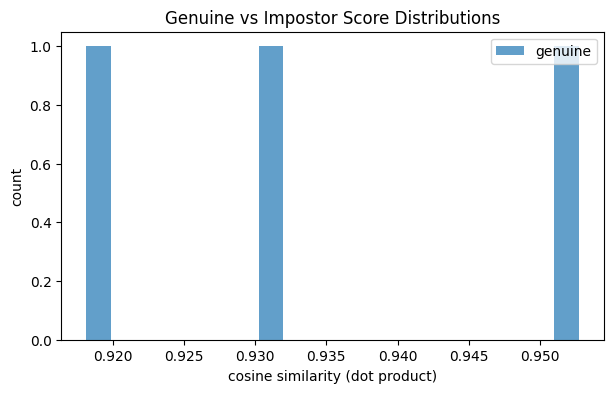

Not enough data to propose thresholds. Add >=2 users and >=2 images per user.


In [38]:
import itertools
from collections import defaultdict

# Collect embeddings per user from enrollment_samples
user_embeddings: dict[str, list[np.ndarray]] = defaultdict(list)
failures: list[str] = []

for user_dir in sorted([d for d in ENROLLMENT_SAMPLES_DIR.iterdir() if d.is_dir()]):
    user_id = user_dir.name
    paths = list_images(user_dir)[:MAX_IMAGES]
    for p in paths:
        try:
            bgr = load_image_bgr(p)
            face = detect_one_face(bgr)
            q = quality_checks(bgr, face.bbox)
            ok, reasons = passes_quality(q)
            if not ok:
                failures.append(f"{user_id}/{p.name}: {reasons}")
                continue
            emb = extract_embedding(face)
            user_embeddings[user_id].append(emb)
        except Exception as e:
            failures.append(f"{user_id}/{p.name}: {e}")

print("users with embeddings:", {k: len(v) for k, v in user_embeddings.items()})
print("failures:", len(failures))

# Genuine scores (within same user)
genuine_scores: list[float] = []
for user_id, embs in user_embeddings.items():
    if len(embs) >= 2:
        for a, b in itertools.combinations(embs, 2):
            genuine_scores.append(float(np.dot(a, b)))

# Impostor scores (between users, compare mean templates)
user_means = {
    u: l2_normalize(np.mean(np.stack(embs, axis=0), axis=0))
    for u, embs in user_embeddings.items() if len(embs) >= 1
}

impostor_scores: list[float] = []
for (u1, e1), (u2, e2) in itertools.combinations(user_means.items(), 2):
    impostor_scores.append(float(np.dot(e1, e2)))

print(f"genuine_scores: {len(genuine_scores)}, impostor_scores: {len(impostor_scores)}")

# Plot distributions (if available)
if genuine_scores or impostor_scores:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(7, 4))
    if genuine_scores:
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="genuine")
    if impostor_scores:
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="impostor")
    plt.xlabel("cosine similarity (dot product)")
    plt.ylabel("count")
    plt.legend()
    plt.title("Genuine vs Impostor Score Distributions")
    plt.show()

# Propose thresholds
if genuine_scores and impostor_scores:
    T_low = float(np.percentile(impostor_scores, 99))   # fail below this
    T_high = float(np.percentile(genuine_scores, 10))   # pass above this
    if T_low > T_high:
        mid = (T_low + T_high) / 2.0
        T_low = mid - 0.02
        T_high = mid + 0.02
    print({"T_low": round(T_low, 4), "T_high": round(T_high, 4)})
else:
    print("Not enough data to propose thresholds. Add >=2 users and >=2 images per user.")

